# 1. Library Imports


In this section, we import all the necessary libraries for data preprocessing, tokenization, model training, and evaluation.


In [4]:
from typing import Dict, List, Optional, Tuple
import torch
from torch.utils.data import Dataset
from transformers import (
    BertTokenizerFast,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
    EvalPrediction,
)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import random
from sklearn.model_selection import train_test_split

# Creation Dataset

In [2]:
class AbstractsDataset(Dataset):
    """
    PyTorch Dataset for abstracts classification.

    Args:
        texts (List[str]): List of raw abstract texts.
        labels (Optional[List[int]]): List of integer labels. Optional for inference.
        tokenizer (BertTokenizerFast): Pretrained tokenizer.
        max_length (int): Max token length for padding/truncation.

    Returns:
        Dict[str, torch.Tensor]: Tokenized inputs and labels (if given).
    """

    def __init__(
        self,
        texts: List[str],
        labels: Optional[List[int]],
        tokenizer: BertTokenizerFast,
        max_length: int = 512,
    ):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self) -> int:
        return len(self.texts)

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors="pt",
        )
        item = {k: v.squeeze(0) for k, v in encoding.items()}
        if self.labels is not None:
            item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item



In [5]:
class BertClassifier:
    """
    Wrapper for BERT fine-tuning on text classification using HuggingFace Trainer.

    Args:
        model_name (str): Name of pretrained BERT model.
        num_labels (int): Number of output classes.
        device (torch.device): Device to run model on.
    """

    def __init__(self, model_name: str, num_labels: int, device: torch.device):
        self.device = device
        self.model_name = model_name
        self.num_labels = num_labels
        self.tokenizer = BertTokenizerFast.from_pretrained(model_name)
        self.model = BertForSequenceClassification.from_pretrained(
            model_name, num_labels=num_labels
        ).to(device)
        self.trainer: Optional[Trainer] = None
        self.training_history: Dict[str, List[float]] = {}

    def compute_metrics(self, p: EvalPrediction) -> Dict[str, float]:
        """
        Compute accuracy metric for evaluation.

        Args:
            p (EvalPrediction): HuggingFace prediction object with logits and labels.

        Returns:
            Dict[str, float]: Dictionary with accuracy.
        """
        preds = np.argmax(p.predictions, axis=1)
        return {"accuracy": accuracy_score(p.label_ids, preds)}

    def train(
        self,
        train_dataset: Dataset,
        val_dataset: Dataset,
        output_dir: str,
        epochs: int = 3,
        batch_size: int = 16,
        learning_rate: float = 5e-5,
        weight_decay: float = 0.01,
    ) -> None:
        """
        Fine-tune BERT model on training dataset with validation.

        Args:
            train_dataset (Dataset): Training dataset.
            val_dataset (Dataset): Validation dataset.
            output_dir (str): Directory to save checkpoints.
            epochs (int): Number of epochs.
            batch_size (int): Batch size.
            learning_rate (float): Learning rate.
            weight_decay (float): Weight decay for optimizer.
        """
        training_args = TrainingArguments(
            output_dir=output_dir,
            num_train_epochs=epochs,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            eval_strategy="epoch",
            save_strategy="epoch",
            learning_rate=learning_rate,
            weight_decay=weight_decay,
            logging_dir=f"{output_dir}/logs",
            logging_strategy="epoch",
            load_best_model_at_end=True,
            metric_for_best_model="accuracy",
            greater_is_better=True,
            save_total_limit=2,
            seed=42,
            report_to="none",
            gradient_checkpointing = True,
            gradient_checkpointing_kwargs = {"use_reentrant": False},
        )

        self.trainer = Trainer(
            model=self.model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            compute_metrics=self.compute_metrics,
        )
        train_result = self.trainer.train()
        self.training_history = self.trainer.state.log_history

    def evaluate(self, dataset: Dataset) -> Dict[str, float]:
        """
        Evaluate model on given dataset.

        Args:
            dataset (Dataset): Dataset to evaluate on.

        Returns:
            Dict[str, float]: Evaluation metrics including loss and accuracy.
        """
        assert self.trainer is not None, "Trainer not initialized, train first."
        metrics = self.trainer.evaluate(eval_dataset=dataset)
        return metrics

    def predict(self, texts: List[str], max_length: int = 512) -> List[int]:
        """
        Run inference on raw texts, returning predicted class indices.

        Args:
            texts (List[str]): List of raw texts to classify.
            max_length (int): Max token length for tokenizer.

        Returns:
            List[int]: Predicted class indices.
        """
        encodings = self.tokenizer(
            texts, truncation=True, padding=True, max_length=max_length, return_tensors="pt"
        )
        input_ids = encodings["input_ids"].to(self.device)
        attention_mask = encodings["attention_mask"].to(self.device)

        self.model.eval()
        with torch.no_grad():
            outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=-1)
        return preds.cpu().tolist()

    def plot_losses(self) -> None:
        """
        Plot training and validation losses over epochs.
        """
        if not self.training_history:
            raise ValueError("No training history found. Train the model first.")

        epochs = []
        train_losses = []
        val_losses = []

        for record in self.training_history:
            if "epoch" in record:
                epochs.append(record["epoch"])
            if "loss" in record:
                train_losses.append(record["loss"])
            if "eval_loss" in record:
                val_losses.append(record["eval_loss"])

        plt.plot(epochs[:len(train_losses)], train_losses, label="Train Loss")
        plt.plot(epochs[:len(val_losses)], val_losses, label="Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.title("Training and Validation Loss")
        plt.show()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/carmine/miniconda3/envs/d2l/lib/python3.9/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy
1,1.751400,2.525928,0.000000
2,1.599600,2.430017,0.000000


/home/carmine/miniconda3/envs/d2l/lib/python3.9/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/carmine/miniconda3/envs/d2l/lib/python3.9/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Evaluation metrics: {'eval_loss': 2.525928497314453, 'eval_accuracy': 0.0, 'eval_runtime': 1.7468, 'eval_samples_per_second': 1.145, 'eval_steps_per_second': 0.572, 'epoch': 2.0}
Predicted classes: [0, 0]


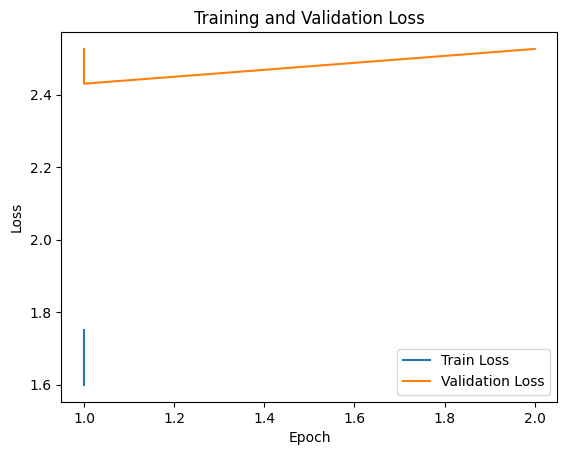

In [6]:

# Suppose this is your minimal dataset of abstracts and their macro-topic labels
dummy_texts = [
    "This paper explores the use of machine learning for cancer diagnosis.",
    "A novel method for renewable energy storage is proposed.",
    "The study investigates climate change impacts on marine life.",
    "We present a new approach to natural language processing.",
    "Research on quantum computing and its applications.",
    "Analysis of economic factors influencing global markets.",
    "A deep dive into reinforcement learning algorithms.",
    "Evaluating social policies in urban development.",
    "Advancements in battery technology for electric vehicles.",
    "The role of AI in personalized medicine.",
]

# Dummy labels (e.g., 0: healthcare, 1: energy, 2: environment, etc.)
dummy_labels = [0, 1, 2, 0, 3, 4, 0, 5, 1, 0]

# Split into train and validation sets (80% train, 20% val)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    dummy_texts, dummy_labels, test_size=0.2, random_state=42
)

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model wrapper (number of unique classes)
num_classes = len(set(dummy_labels))
bert_clf = BertClassifier("bert-base-uncased", num_classes, device)

# Prepare datasets
train_ds = AbstractsDataset(train_texts, train_labels, bert_clf.tokenizer)
val_ds = AbstractsDataset(val_texts, val_labels, bert_clf.tokenizer)

# Train for 2 epochs (just for test)
bert_clf.train(train_ds, val_ds, output_dir="../Script", epochs=2, batch_size=2)

# Evaluate on validation set
eval_metrics = bert_clf.evaluate(val_ds)
print("Evaluation metrics:", eval_metrics)

# Inference on new samples
test_samples = [
    "Innovative techniques in AI for healthcare applications.",
    "New solar panel design improves efficiency.",
]
predictions = bert_clf.predict(test_samples)
print("Predicted classes:", predictions)

# Plot training and validation loss
bert_clf.plot_losses()
